# Eval Masks
This notebook contains visualisation to qualitatively analyse the masks.

In [133]:
%load_ext autoreload
%autoreload 2

import os
import torch

import matplotlib.pyplot as plt
import numpy as np

from diveslowlearnfast.train.helper import get_test_transform
from diveslowlearnfast.datasets import Diving48Dataset
from diveslowlearnfast.config import Config
from diveslowlearnfast.train import StatsDB
from diveslowlearnfast.utils import tensor_denorm
from diveslowlearnfast.train import helper as train_helper
from diveslowlearnfast.models import load_checkpoint, SlowFast
from torch.utils.data import DataLoader
from diveslowlearnfast.egl import ExplainerStrategy
from diveslowlearnfast.models.utils import to_slowfast_inputs
from diveslowlearnfast.egl.generate_masks import _generate_masks
from diveslowlearnfast.visualise.create_heatmap import create_heatmaps
from diveslowlearnfast.train.stats import wps_strategy


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
cfg = Config()
cfg.EGL.MASKS_CACHE_DIR = './.masks'
cfg.DATA.TEST_CROP_SIZE = 224
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.TRAIN.BATCH_SIZE = 2

In [4]:
stats_db = StatsDB('./data/stats.db')
difficult_samples = stats_db.get_below_median_samples(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)
video_ids = list(map(lambda x: x.replace('.npy', ''), os.listdir('./.masks/slow')))

len(video_ids)

24

In [5]:
train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
    masks_cache_dir=cfg.EGL.MASKS_CACHE_DIR,
    video_ids=video_ids
)
assert len(train_dataset) == len(video_ids)

In [15]:

idx = 0
video_id = train_dataset.data[idx]['vid_name']
video, *_ = train_dataset._read_frames(video_id)
mslow, mfast = train_dataset._read_mask(video_id, 224, 224)

video = tensor_denorm(video, torch.tensor(cfg.DATA.MEAN), torch.tensor(cfg.DATA.STD))
video.shape, mslow.shape, mfast.shape

(torch.Size([32, 224, 224, 3]), (1, 4, 224, 224), (1, 32, 224, 224))

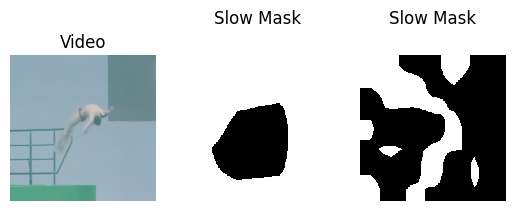

In [22]:
frame_idx = 24
ax = plt.subplot(131)
ax.imshow(video[frame_idx // 8])
ax.axis('off')
ax.set_title('Video')

ax = plt.subplot(132)
ax.matshow(mslow[0][frame_idx // 8], cmap='gray')
ax.axis('off')
ax.set_title('Slow Mask')

ax = plt.subplot(133)
ax.matshow(mfast[0][frame_idx], cmap='gray')
ax.axis('off')
ax.set_title('Slow Mask')

plt.show()

## w/ Model heatmaps

In [24]:
cfg.GRADCAM.TARGET_LAYERS = ['s5/pathway0_res2', 's5/pathway1_res2']
device = torch.device('cpu')
model = SlowFast(cfg)
_, optimiser, *_ = train_helper.get_train_objects(cfg, model, device)
model, *_ = load_checkpoint(model, optimiser, '../misc/checkpoint.pth', device)
explainer = ExplainerStrategy.get_explainer(model, cfg=cfg, device=device)

train_dataset = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=get_test_transform(cfg),  # use test_transform instead
    use_decord=cfg.DATA_LOADER.USE_DECORD,
    temporal_random_jitter=cfg.DATA.TEMPORAL_RANDOM_JITTER,
    temporal_random_offset=cfg.DATA.TEMPORAL_RANDOM_OFFSET,
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    threshold=cfg.DATA.THRESHOLD,
    use_dynamic_temporal_stride=cfg.DATA.USE_DYNAMIC_TEMPORAL_STRIDE,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

In [25]:
xb, yb, _, _, _, mslow, mfast = next(iter(train_loader))

In [72]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, yb)
heatmaps = create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
masks = [torch.from_numpy(_generate_masks(map, percentile=50, invert=True)) for map in localisation_maps]

In [54]:
heatmaps[0].shape, masks[0].shape

(torch.Size([2, 4, 3, 224, 224]), torch.Size([2, 1, 4, 224, 224]))

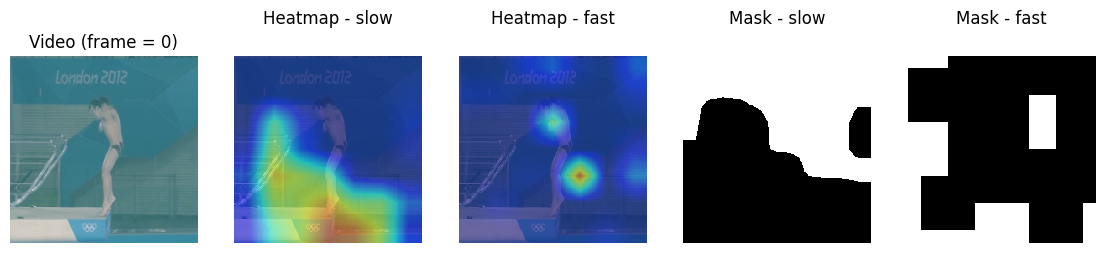

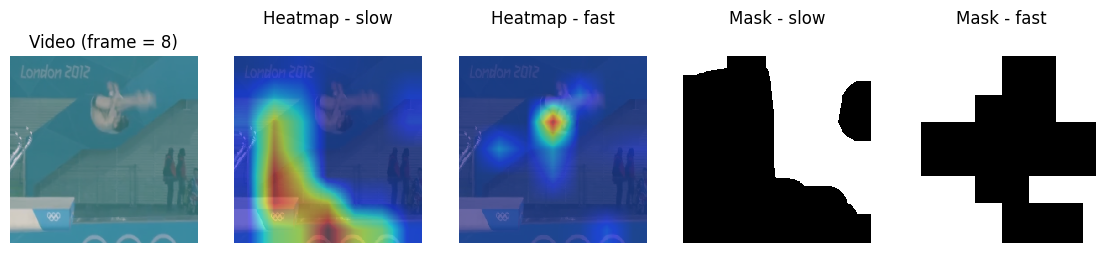

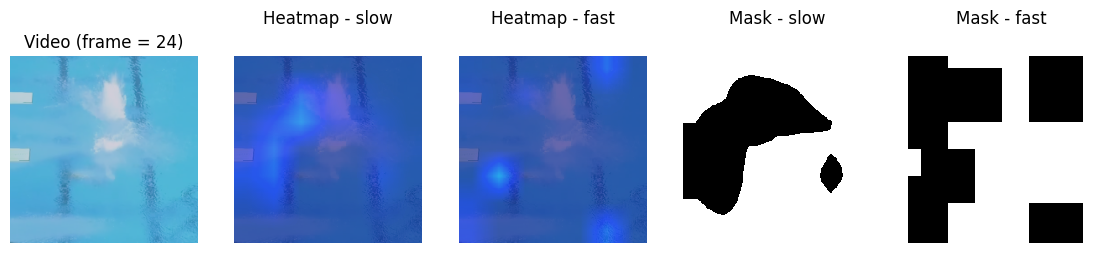

In [74]:
def plot_maps(xb, heatmaps, masks, batch_idx, frame_idx):
    video = tensor_denorm(xb, torch.tensor(cfg.DATA.MEAN), torch.tensor(cfg.DATA.STD))
    plt.figure(figsize=(14, 14))

    ax = plt.subplot(151)
    ax.imshow(video[batch_idx][frame_idx])
    ax.axis('off')
    ax.set_title(f'Video (frame = {frame_idx})')

    ax = plt.subplot(152)
    ax.matshow(heatmaps[0][batch_idx].permute(0, 2, 3, 1)[frame_idx // 8])
    ax.axis('off')
    ax.set_title('Heatmap - slow')

    ax = plt.subplot(153)
    ax.matshow(heatmaps[1][batch_idx].permute(0, 2, 3, 1)[frame_idx])
    ax.axis('off')
    ax.set_title('Heatmap - fast')

    ax = plt.subplot(154)
    ax.matshow(masks[0][batch_idx][0][frame_idx // 8], cmap='gray')
    ax.axis('off')
    ax.set_title('Mask - slow')


    ax = plt.subplot(155)
    ax.matshow(masks[1][batch_idx][0][frame_idx], cmap='gray')
    ax.axis('off')
    ax.set_title('Mask - fast')
    plt.show()


plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=0)
plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=8)
plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=24)

In [70]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, yb)
heatmaps = create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
masks = [torch.from_numpy(_generate_masks(map, percentile=50, invert=False)) for map in localisation_maps]

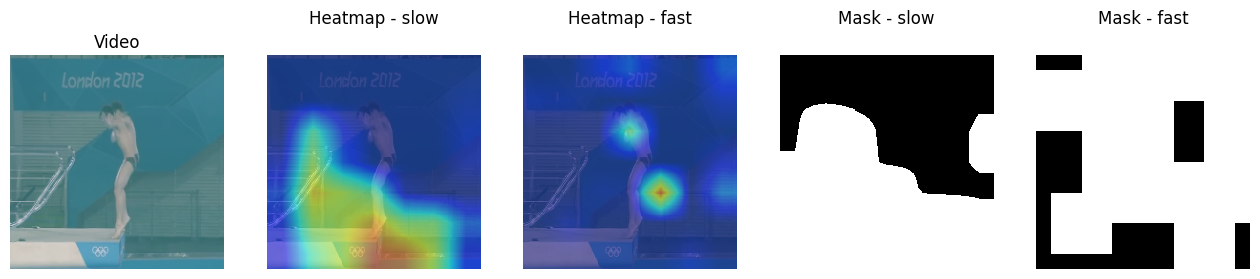

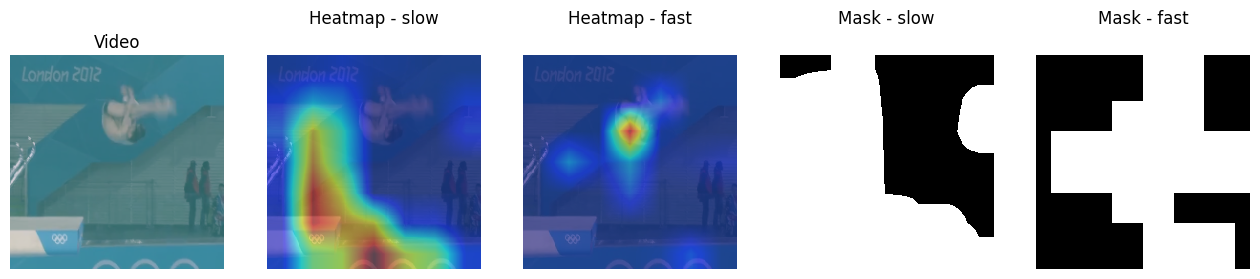

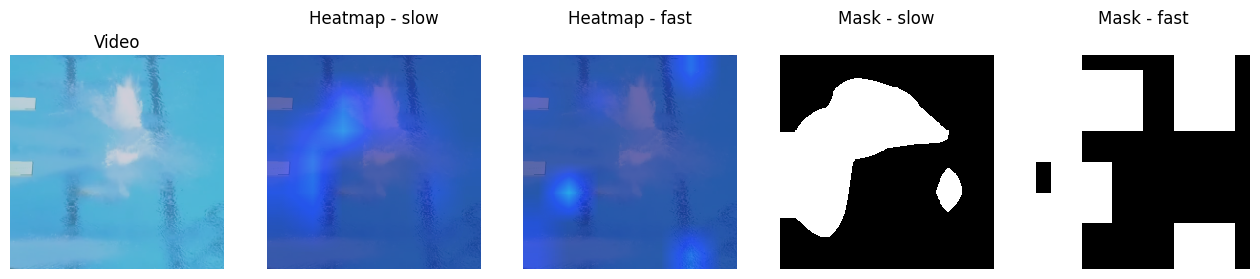

In [71]:
plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=0)
plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=8)
plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=24)

In [75]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, yb)
heatmaps = create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
masks = [torch.from_numpy(_generate_masks(map, percentile=67, invert=False)) for map in localisation_maps]

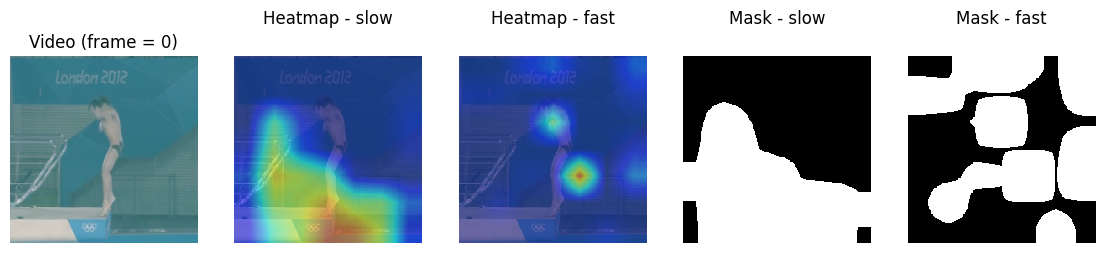

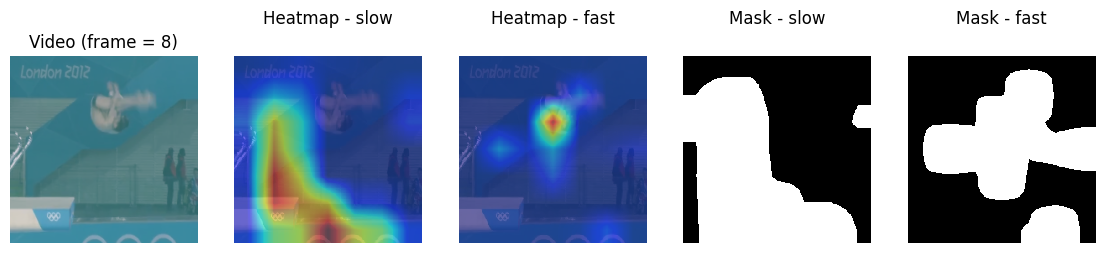

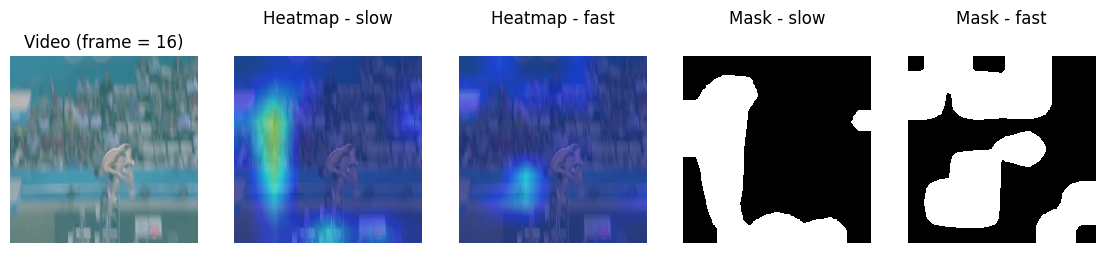

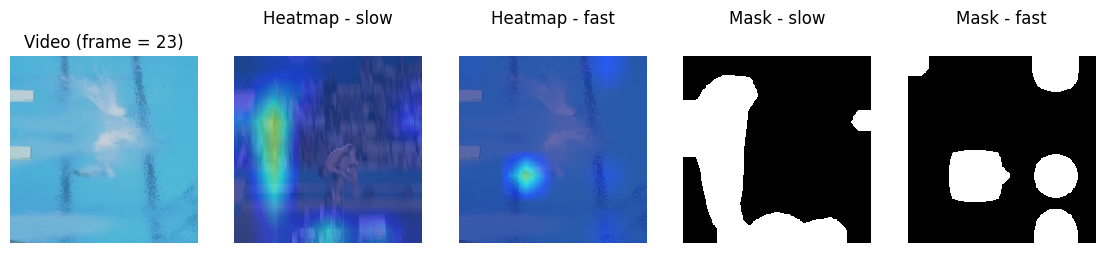

In [77]:
for frame_idx in [0, 8, 16, 23]:
    plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=frame_idx)

In [78]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, yb)
heatmaps = create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
masks = [torch.from_numpy(_generate_masks(map, percentile=80, invert=False)) for map in localisation_maps]

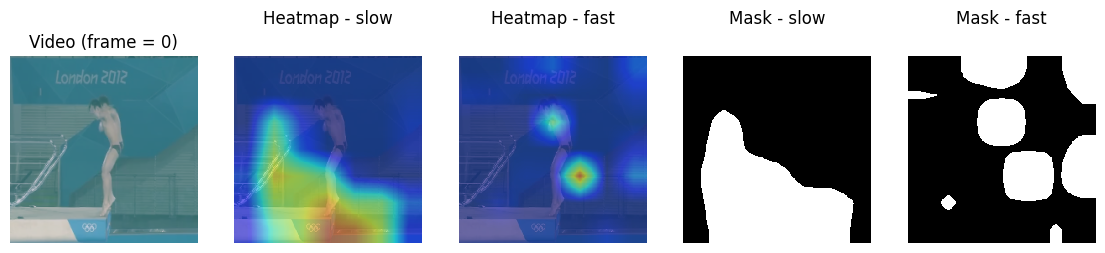

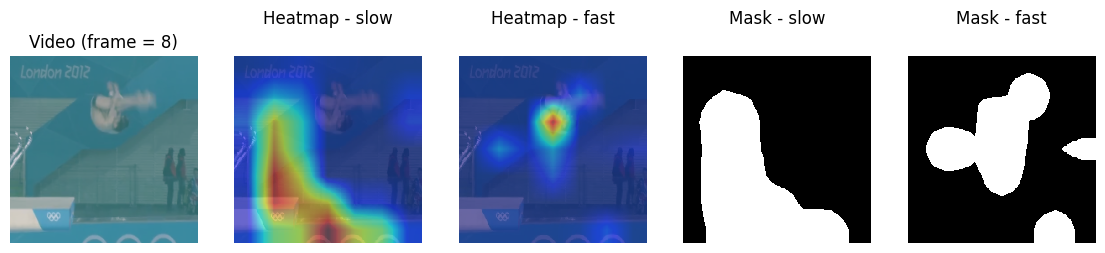

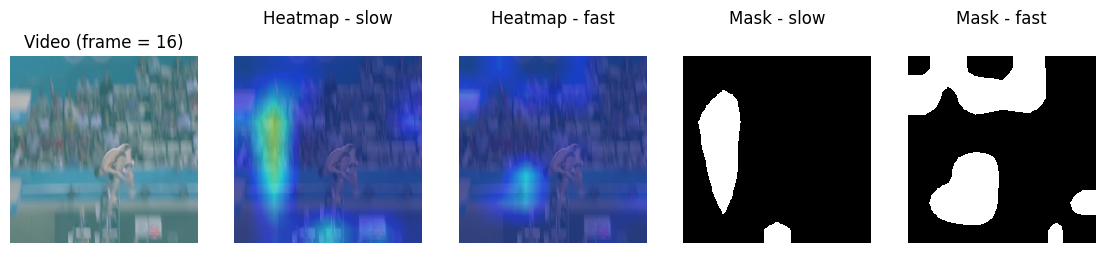

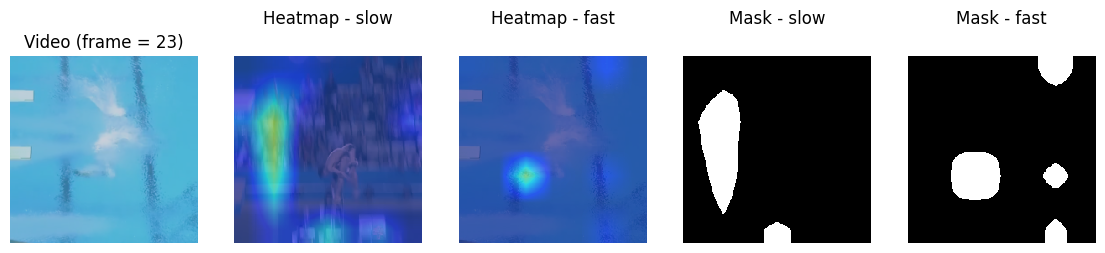

In [79]:
for frame_idx in [0, 8, 16, 23]:
    plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=frame_idx)

In [114]:
inputs = to_slowfast_inputs(xb, alpha=cfg.SLOWFAST.ALPHA)
localisation_maps, logits = explainer(inputs, yb)
heatmaps = create_heatmaps(inputs, localisation_maps, cfg.DATA.MEAN, cfg.DATA.STD, colormap='jet')
masks = [torch.from_numpy(_generate_masks(map, percentile=95, invert=False)) for map in localisation_maps]

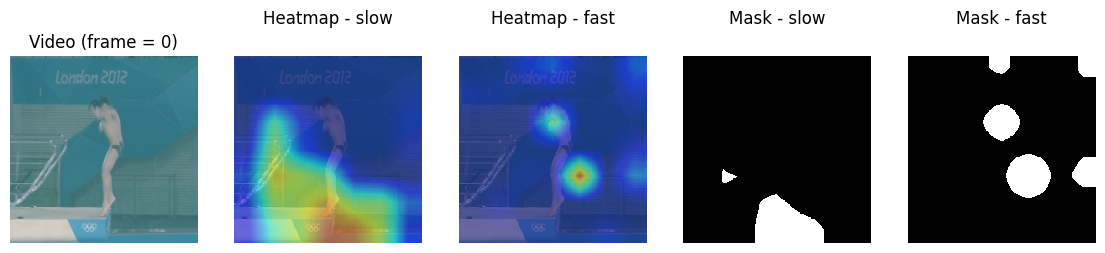

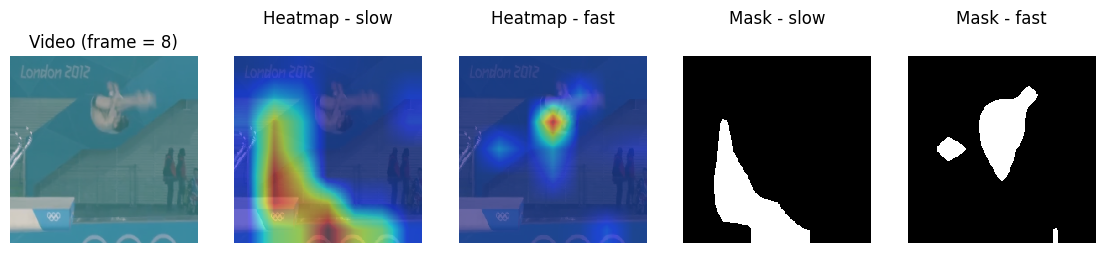

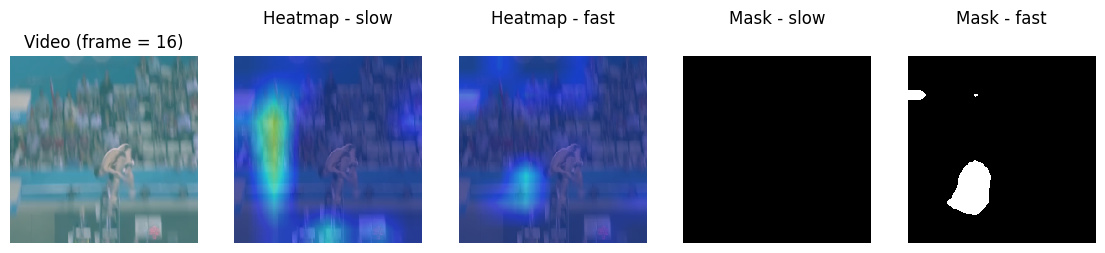

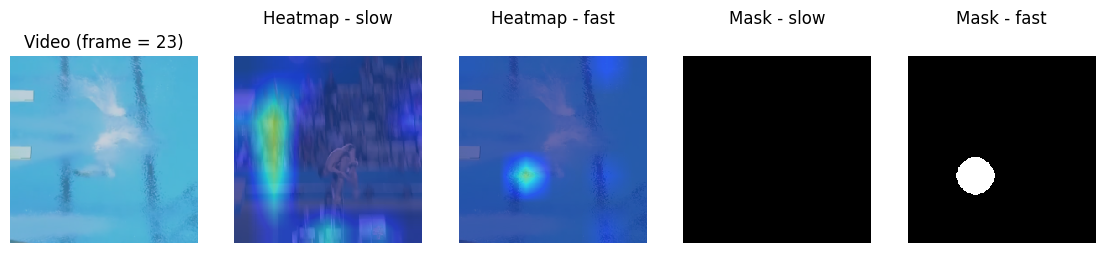

In [115]:
for frame_idx in [0, 8, 16, 23]:
    plot_maps(xb, heatmaps, masks, batch_idx=1, frame_idx=frame_idx)

In [122]:
stats_db = StatsDB('./data/stats.db')
sample_accuracy = stats_db.get_sample_accuracy(
    epoch_start=90,
    run_id='/home/s2871513/Projects/diveslowlearnfast/results/run18',
    split='train'
)

top_n = int(len(sample_accuracy) * 0.05)

top_n, sample_accuracy[:top_n]

(315,
 [['3N1kUtqJ25A_00065', 26, 0.0],
  ['3N1kUtqJ25A_00185', 35, 0.0],
  ['3PLiUG_DuC8_00167', 21, 0.0],
  ['9BC6ssCjyfg_00232', 43, 0.0],
  ['9jZYYtzYqwE_00081', 43, 0.0],
  ['Bb0ZiYVNtDs_00072', 22, 0.0],
  ['D6zILEKIJbk_00190', 43, 0.0],
  ['JzOshOJgofw_00022', 46, 0.0],
  ['JzOshOJgofw_00196', 26, 0.0],
  ['LNMISxO35S0_00149', 5, 0.0],
  ['OFxuiqI5G44_00374', 24, 0.0],
  ['OVzt2rsfMc0_00016', 34, 0.0],
  ['OVzt2rsfMc0_00239', 8, 0.0],
  ['OVzt2rsfMc0_00414', 21, 0.0],
  ['Q--70-ELqLw_00046', 12, 0.0],
  ['RWNrARSbRCY_00043', 33, 0.0],
  ['S9aCrmtAV8o_00127', 26, 0.0],
  ['VNvb5oLOpLg_00253', 19, 0.0],
  ['VNvb5oLOpLg_00374', 24, 0.0],
  ['VNvb5oLOpLg_00375', 24, 0.0],
  ['VNvb5oLOpLg_01145', 21, 0.0],
  ['Y7QZcr24ye0_00016', 19, 0.0],
  ['Y7QZcr24ye0_00024', 19, 0.0],
  ['Y7QZcr24ye0_00572', 24, 0.0],
  ['Y7QZcr24ye0_00751', 36, 0.0],
  ['Y7QZcr24ye0_00865', 34, 0.0],
  ['Y7QZcr24ye0_00909', 24, 0.0],
  ['Y7QZcr24ye0_00984', 17, 0.0],
  ['_8Vy3dlHg2w_00120', 34, 0.0],
  ['_8Vy3d

In [124]:
6300 * 0.05

315.0

In [130]:
worst_performing_samples = stats_db.get_lowest_percentile(90, '/home/s2871513/Projects/diveslowlearnfast/results/run18', 'train', percentile=5)
len(worst_performing_samples)

315

In [135]:
cfg.EGL.WORST_PERFORMER_STRATEGY = 'percentile'
cfg.EGL.WORST_PERFORMER_PERCENTILE = 20

strategy = wps_strategy(stats_db, cfg)

strategy, len(strategy(90, '/home/s2871513/Projects/diveslowlearnfast/results/run18', 'train'))

(<function diveslowlearnfast.train.stats.wps_strategy.<locals>._wsp_percentile_strategy(epoch_start, run_id, split, epoch_end: int | str = 'max_epoch')>,
 1260)

In [136]:
cfg.EGL.WORST_PERFORMER_STRATEGY = 'median'
cfg.EGL.WORST_PERFORMER_PERCENTILE = 20

strategy = wps_strategy(stats_db, cfg)

strategy, len(strategy(90, '/home/s2871513/Projects/diveslowlearnfast/results/run18', 'train'))

(<bound method StatsDB.get_below_median_samples of <diveslowlearnfast.train.stats.StatsDB object at 0x323c00d70>>,
 3144)